# Building a Model

In this part of the tutorial, we'll walk through the task of building a model with MEDS

We will continue exactly where we've left off in the previous part of the tutorial. Our task is to predict *a short ICU stay* (of < 3 days) given the patient's input data. We have already transformed the dataset into the MEDS format and extracted a set of label files for the dataset.

Let's download the files we produced in the prior sections from the tutorial resources:

In [ ]:
%%bash
wget -q -c https://github.com/Medical-Event-Data-Standard/MEDS_KDD_2025_Tutorial/raw/refs/heads/main/MEDS_data.zip

unzip -q -o MEDS_data.zip

apt-get -qq install tree
tree MEDS_data

MEDS_data
├── data
│   ├── held_out
│   │   └── 0.parquet
│   ├── train
│   │   └── 0.parquet
│   └── tuning
│       └── 0.parquet
├── labels
│   └── short_LOS
│       ├── held_out
│       │   └── 0.parquet
│       ├── train
│       │   └── 0.parquet
│       └── tuning
│           └── 0.parquet
└── metadata
    ├── codes.parquet
    ├── dataset.json
    └── subject_splits.parquet

10 directories, 9 files


We can see that we have our core "data" files in `MEDS_data/data`, our metadata files in `MEDS_data/metadata`, and our task labels in `MEDS_data/labels/short_LOS`. We'll store these paths in variables for ease of use later.

In [ ]:
from pathlib import Path
data_root = Path("MEDS_data/data")
labels_root = Path("MEDS_data/labels/short_LOS")
metadata_root = Path("MEDS_data/metadata")

To help us get started, let's look at some of our core data files and our label files:

In [ ]:
import pandas as pd

train_data = pd.read_parquet(data_root / "train")

# Remember that MEDS lets you store arbitrary other columns beyond those in the
# official schema -- we'll simplify things here by just keeping the main 5:
train_data = train_data[
  ["subject_id", "time", "code", "numeric_value", "text_value"]
]
display(train_data.head())

train_labels = pd.read_parquet(labels_root / "train")

# Similarly, we'll only keep the relevant boolean label in our labels
train_labels = train_labels[["subject_id", "prediction_time", "boolean_value"]]

display(train_labels.head())

,subject_id,time,code,numeric_value,text_value
0,10000032,NaT,GENDER//F,NaN,None
1,10000032,2128-01-01 00:00:00,MEDS_BIRTH,NaN,None
2,10000032,2180-03-23 11:51:00,LAB//51087//UNK,NaN,None
3,10000032,2180-03-23 11:51:00,LAB//50940//UNK,NaN,None
4,10000032,2180-03-23 11:51:00,LAB//51079//UNK,NaN,NEG


,subject_id,prediction_time,boolean_value
0,10002428,2156-04-13 16:24:18,False
1,10002428,2156-04-20 18:11:19,False
2,10002428,2156-05-01 21:53:00,True
3,10002428,2156-05-12 14:49:34,False
4,10002495,2141-05-23 20:18:01,False


Now that we have our files again and know what our data looks like, we will learn how to use MEDS datasets to train a couple of different kinds of models.

First, it is a good practice to start from a baseline model over some tabularized features representing the patient's data.
We will start by extracting these features manually, which is viable on our demo dataset given its small size.
To show you how to scale this up to a much larger dataset, we will also show how you could use the [MEDS-Tab](https://github.com/mmcdermott/MEDS_Tabular_AutoML) tool to do this.

Once that is done, we will show how you could build a simple neural network model for this task, highlighting a few different other tools in the process.

Let's dive in!

## A Tabular Baseline


### MEDS Format vs Tabularized Data

The first step in training a tabular model on a MEDS dataset is to prepare the data, as there are some important differences between MEDS representation and the usual "tabular" representation:

* **MEDS** has the "one row = one event" structure. Every patient will usually have many events (such as birth, death, hospital admission, lab results, diagnostic codes, etc.) associated with them, and each of these events will be represented in their own row.
* **Tabular** data is typically treated as having a "one row = one training sample" structure, which would correspond to each patient -- along with their *whole history* of measurements -- being represented as a *single* row in the dataset.

For example, we can see that the first subject in our MEDS training dataset has quite a few measurements (rows) associated with them.

In [ ]:
sample_subject = train_labels.iloc[0]["subject_id"]
display(train_data[train_data['subject_id'] == sample_subject])

,subject_id,time,code,numeric_value,text_value
4860,10002428,NaT,GENDER//F,NaN,None
4861,10002428,2075-01-01 00:00:00,MEDS_BIRTH,NaN,None
4862,10002428,2154-08-12 00:00:00,Weight (Lbs),NaN,98
4863,10002428,2154-08-12 00:00:00,BMI (kg/m2),NaN,19.6
4864,10002428,2154-08-12 00:00:00,Blood Pressure,NaN,158/98
...,...,...,...,...,...
41436,10002428,2160-07-16 18:49:00,DIAGNOSIS//ICD//10//S4992XA,NaN,None
41437,10002428,2160-07-16 18:49:00,DIAGNOSIS//ICD//10//Z9181,NaN,None
41438,10002428,2160-07-16 18:49:00,DIAGNOSIS//ICD//10//M3500,NaN,None
41439,10002428,2160-07-16 18:49:00,TRANSFER_TO//admit//Emergency Department Obser...,NaN,None


If we want to train a simple baseline model (e.g., logistic regression, XGBoost, etc.), all these measurements will eventually have to be summarized into a single, fixed-size representation, and the overall structure of our tabularized dataset will look more like this:

| `subject_id` | `feature_1` | `feature_2` | ... |
|:-:|:-:|:-:|:-:|
| 10000032 | ? | ? | ... |
| 10001217 | ? | ? | ... |
| ... | ... | ... | ... |

Note there's actually one more complexity here -- we actually don't want _all_ of the subject's measurements included in that fixed-size tabular input. Instead, we just want those that are "permitted inputs" for a given task sample. Let's look at our label dataframe again:

In [ ]:
train_labels[train_labels["subject_id"] == sample_subject]

,subject_id,prediction_time,boolean_value
0,10002428,2156-04-13 16:24:18,False
1,10002428,2156-04-20 18:11:19,False
2,10002428,2156-05-01 21:53:00,True
3,10002428,2156-05-12 14:49:34,False


We can see that there are actually multiple "task samples" for this subject, each with different `prediction_time` inputs! Moreover, all available subject data for each of these samples could potentially lead to *data leakage* -- that is, "future" patient data being available for an earlier prediction time.

What this means is that we want to find a way to summarize all of the patient's data up to and including each of these time points separately, and use the appropriate summary to predict each sample's label -- adding another dimension to our "tabularization process".

### Tabularization Strategy

Clearly, tabularization must follow the following strategy: for each prediction time of interest, we'll pick a set of "features" we want to extract about the patient's data up to that time, and write code to extract those features. Those will then be our columns in our tabular representation.

But with the MEDS format, we can be a bit more specific. In particular, we can ask "what is a _feature_ when derived from MEDS data?" Given the structure of MEDS, an easy template to use is the following:

> _Given a patient's MEDS data and a prediction time, a "feature" is an aggregation function applied to a filtered set of measurements that occur in some relative or absolute window prior to the prediction time._

With this in mind, to define a feature, we just need to decide (1) what's our aggregation function, (2) what filtered set of measurements should we use, and (3) what is our window prior to the prediction time.

This is still a broad definition, but it lets us operationalize things very cleanly. Let's see this idea in action by constructing some features on the MEDS data we have.


### Constructing the Features

So how do we featurize a MEDS dataset into a tabular form?

We could start from exploring all the event codes appearing in a MEDS dataset. To help us do that, here's a simple helper that will let us search through the columns of a dataframe interactively.

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from functools import partial

def df_search(df: pd.DataFrame):
  # Create a Text widget for the search input
  search_input = widgets.Text(
      value='',
      placeholder='Enter search term...',
      description='Search:',
      disabled=False
  )

  # Function to filter the DataFrame based on the search term
  def filter_dataframe(df: pd.DataFrame, search_term: str):
      if not search_term:
        display(df)
      else:
        filtered_df = df[df.apply(lambda row: row.astype(str).str.contains(search_term, case=False).any(), axis=1)]
        display(filtered_df)

  # Create an interactive output to display the filtered DataFrame
  output = widgets.interactive_output(
      partial(filter_dataframe, df=df), {'search_term': search_input}
  )

  # Display the search input and the output
  display(search_input, output)

Let's start by exploring the `codes.parquet` dataframe within a MEDS dataset's `metadata` directory:

In [ ]:
metadata_df = pd.read_parquet(metadata_root / "codes.parquet")
df_search(metadata_df)

Text(value='', description='Search:', placeholder='Enter search term...')

Output()

We can also search through the code strings or text values associated with them in the training data directly:

In [ ]:
df_search(train_data[["code", "text_value"]].drop_duplicates())

Text(value='', description='Search:', placeholder='Enter search term...')

Output()

For MIMIC-IV data specifically, we can also use another resource from the raw data, which may help interpret some of the potentially uninformative codes in the training data (e.g. try searching for `220046` in `metadata_df`, `train_data` as well as the table below).

In [ ]:
!wget -q -c https://physionet.org/files/mimic-iv-demo/1.0/icu/d_items.csv.gz
mimic_icu_d_items = pd.read_csv("d_items.csv.gz")
df_search(mimic_icu_d_items)

Text(value='', description='Search:', placeholder='Enter search term...')

Output()

However, using every code appearing in the train dataset as a feature leads to two challenges:

* There might be a lot of **missing data**, since most of these codes are rare and would only appear for a few patients (especially when we narrow down our cohort as part of the task and label extraction process),
* Many of these codes could have **many measurements over time**.

For example, let's look for the codes measuring the white blood cell (leukocyte) count, as those could indicate an infection.

In [ ]:
display(metadata_df[metadata_df['description'].str.contains('leukocyte', case=False, na=False)].head(30))

,code,description,parent_codes,itemid,possibly_cpt_code,valueuom
33,LAB//51124//%,Plasma cells/100 leukocytes in Peritoneal flui...,[LOINC/40518-3],[51124],[None],[%]
85,LAB//52272//%,Monocytes/100 leukocytes in Cerebral spinal fluid,[LOINC/26486-1],[52272],[None],[%]
127,LAB//51118//%,Mesothelial cells/100 leukocytes in Peritoneal...,[LOINC/30432-9],[51118],[None],[%]
133,LAB//51448//%,Mesothelial cells/100 leukocytes in Pleural fluid,[LOINC/30431-1],[51448],[None],[%]
146,LAB//51263//%,Plasma cells/100 leukocytes in Blood,[LOINC/13047-6],[51263],[None],[%]
222,LAB//51376//%,Macrophages/100 leukocytes in Synovial fluid,[LOINC/33376-5],[51376],[None],[%]
310,LAB//51244//%,Lymphocytes/100 leukocytes in Blood by Automat...,[LOINC/736-9],[51244],[None],[%]
329,LAB//51427//%,Lymphocytes/100 leukocytes in Body fluid,[LOINC/11031-2],[51427],[None],[%]
458,LAB//51117//%,Macrophages/100 leukocytes in Peritoneal fluid...,[LOINC/40517-5],[51117],[None],[%]
492,LAB//51112//%,Basophils/100 leukocytes in Peritoneal fluid,[LOINC/35069-4],[51112],[None],[%]


There seem to be two codes corresponding to the leukocyte count, `LAB//51300//K/uL` and `LAB//51301//K/uL`.

As we group the dataset by these codes, we see that patients could have many measurements for the same type of a vital sign or biomarker.

In [ ]:
mask = train_data['code'].isin(['LAB//51300//K/uL', 'LAB//51301//K/uL'])
display(train_data[mask].groupby('subject_id').describe()['numeric_value'].head())

,count,mean,min,25%,50%,75%,max,std
subject_id,,,,,,,,
10000032,13.0,5.815384,3.0,4.800,5.60,6.900000,8.200000,1.618562
10001217,13.0,10.723078,5.4,8.400,9.70,12.600000,19.000000,3.827130
10002428,57.0,10.873684,3.8,7.100,9.10,11.300000,33.400002,6.166604
10002495,10.0,21.619999,11.0,11.575,23.05,29.099999,36.799999,9.659974
10002930,43.0,3.048837,1.9,2.400,2.90,3.300000,5.000000,0.846666


Since creating a new column for each possible timestamp (not to mention for each possible code) would be infeasible, *how do we appropriately aggregate them into a single column?*
This is where the domain expertise and close collaboration with a clinician is extremely useful -- just like when selecting meaningful prediction tasks and deciding on a patient cohort.

However, as the focus of this notebook is the practical aspect of actually tabularizing selected features and building models, let's just look at a few examples.
For the length of stay task, some features we could reasonably use include:

* **Demographic and admission information**, including birth date (to calculate age at admission), gender, ICU admission type (subtypes of ICU admission by which the patients are filtered into our cohort)
* **Vital signs (min/max/mean over the first 24h)**, such as heart rate, blood pressure, temperature
* **Lab values (min/max/mean over the first 24h)**, e.g. white blood cell (leukocyte) count

Let's find the codes for those features in the dataset.

In [ ]:
search_terms = [
  # Demographics and admission info
  'birth', 'gender', 'icu_admission',
  # Vital signs
  'heart rate', 'blood pressure', 'temperature',
  # Lab values
  r'leukocytes \[\#/volume\]',
]

code_list = []

for s in search_terms:
  print(f"Codes for \"{s}\":\n")
  search_metadata_df = metadata_df[(metadata_df['code'].str.contains(s, case=False)
    | metadata_df['description'].str.contains(s, case=False))]
  if not search_metadata_df.empty:
    for index, row in search_metadata_df.iterrows():
      print(row['code'], '\n\t', row['description'])
      code_list.append(row['code'])
    print()

  search_d_items_df = mimic_icu_d_items[(mimic_icu_d_items['label'].str.contains(s, case=False))]
  if not search_d_items_df.empty:
    # 'itemid' in the D_ITEMS dataframe contains an ID that is reused when
    # constructing the codes in the MEDS dataset,
    # so we search for this ID in training dataframe:
    for i, l in zip(search_d_items_df['itemid'], search_d_items_df['label']):
      search_itemid_in_train_df = train_data[
        (train_data['code'].str.contains(str(i)))]
      if not search_itemid_in_train_df.empty:
        code = search_itemid_in_train_df['code'].unique()[0]
        print(code, '\n\t', l)
        code_list.append(code)

  search_train_df = train_data[(train_data['code'].str.contains(s, case=False))]
  if not search_train_df.empty:
    for c in search_train_df['code'].unique():
      code_list.append(c)
      print(c)

  print("\n")

Codes for "birth":

MEDS_BIRTH


Codes for "gender":

GENDER//F
GENDER//M


Codes for "icu_admission":

ICU_ADMISSION//Medical Intensive Care Unit (MICU)
ICU_ADMISSION//Surgical Intensive Care Unit (SICU)
ICU_ADMISSION//Coronary Care Unit (CCU)
ICU_ADMISSION//Medical/Surgical Intensive Care Unit (MICU/SICU)
ICU_ADMISSION//Trauma SICU (TSICU)
ICU_ADMISSION//Cardiac Vascular Intensive Care Unit (CVICU)
ICU_ADMISSION//Neuro Surgical Intensive Care Unit (Neuro SICU)
ICU_ADMISSION//Neuro Stepdown
ICU_ADMISSION//Neuro Intermediate


Codes for "heart rate":

LAB//220046//bpm 
	 Heart rate Alarm - High
LAB//220047//bpm 
	 Heart Rate Alarm - Low
LAB//220045//bpm 
	 Heart Rate


Codes for "blood pressure":

LAB//227539//UNK 
	 ART Blood Pressure Alarm Source
LAB//227537//mmHg 
	 ART Blood Pressure Alarm - High
LAB//220058//mmHg 
	 Arterial Blood Pressure Alarm - High
LAB//227538//mmHg 
	 ART Blood Pressure Alarm - Low
LAB//223751//mmHg 
	 Non-Invasive Blood Pressure Alarm - High
LAB//223752//mmH

Simplifying this list to account for feature occurrence in our training data, we could get a selection of features like this:

In [ ]:
birth_codes = ["MEDS_BIRTH"]

# Categorical codes
gender_codes = ["GENDER//F", "GENDER//M"]

icu_admission_codes = ['ICU_ADMISSION//Medical Intensive Care Unit (MICU)',
 'ICU_ADMISSION//Surgical Intensive Care Unit (SICU)',
 'ICU_ADMISSION//Coronary Care Unit (CCU)',
 'ICU_ADMISSION//Medical/Surgical Intensive Care Unit (MICU/SICU)',
 'ICU_ADMISSION//Trauma SICU (TSICU)',
 'ICU_ADMISSION//Cardiac Vascular Intensive Care Unit (CVICU)',
 'ICU_ADMISSION//Neuro Surgical Intensive Care Unit (Neuro SICU)',
 'ICU_ADMISSION//Neuro Stepdown',
 'ICU_ADMISSION//Neuro Intermediate',]

# Numeric codes
numeric_codes = ['LAB//223761//°F',
                 'LAB//220179//mmHg', 'LAB//220180//mmHg',
                 'LAB//220050//mmHg', 'LAB//220051//mmHg',
                 'LAB//51301//K/uL']

### Filtering the cohorts

Remember from our previous discussion on tabularization strategy that a "feature" in a tabular dataset consists of three components:

1. aggregation function for a
2. filtered set of measurements, occuring in
3. some window prior to the prediction time.

We have now selected the set of measurements that we will be filtering (component 2): `birth_codes`, `gender_codes`, `icu_admission_codes` and `numeric_codes`.

For the choice of the aggregation function, some of the features do not need an aggregation function, such as age, gender, and ICU admission type -- those features either have a unique value for a particular patient, or, in case of ICU admission, are constrained by our prediction task, as a separate ICU admission is treated as an independent training sample.
In case of numerical features that can potentially have many measurements, we can summarize the data in several ways, but for simplicity we can pick `min()`, `max()` and `mean()` aggregation functions.

The decision on the right aggregation windows again depends on the features. For age and gender, we use information available since the patient's birth, and we could have also used other features spanning through the subject's life up to the prediction time (e.g. number of previous admissions, comorbidities, etc.) For simplicity though, all of our numerical features will be aggregated to over a window from the ICU admission time up to the prediction time, spanning 24 hours.


An example implementation of such tabularization strategy is shown below. This works for our small demo dataset, but with larger scale other practical and efficiency considerations may become more important.

In [ ]:
import numpy as np
def tabularize_data(data, labels):
    featurized_data = []

    for index, row in labels.iterrows():
        features = {}

        subject_id = row['subject_id']
        window_end = row['prediction_time']
        window_start = window_end - pd.Timedelta(days=1)

        features['subject_id'] = subject_id
        features['prediction_time'] = window_end

        # Time-windowed data (within prediction window)
        window_events = data[(data['subject_id'] == subject_id)
                                    & ((data['time'] >= window_start) & (data['time'] <= window_end))]

        # Age calculation
        subject_birth = data[(data['subject_id'] == subject_id) & (data['code'].isin(birth_codes))]
        if len(subject_birth) > 0:
            birth_time = subject_birth['time'].iloc[0]
            if pd.notna(birth_time):
                age = (window_end - birth_time).days / 365.25  # Convert to years
                features['age'] = age
            else:
                features['age'] = np.nan
        else:
            features['age'] = np.nan

        # Gender (categorical)
        subject_gender = data[(data['subject_id'] == subject_id) & (data['code'].isin(gender_codes))]
        if len(subject_gender) > 0:
            gender_code = subject_gender['code'].iloc[0]
            gender = gender_code.split('//')[-1] if '//' in gender_code else gender_code
            features['gender'] = gender
        else:
            features['gender'] = 'Unknown'

        # ICU admission type (categorical)
        icu_admission_type_events = window_events[window_events['code'].isin(icu_admission_codes)]
        if len(icu_admission_type_events) > 0:
            icu_code = icu_admission_type_events['code'].iloc[0]
            icu_type = icu_code.split('//')[-1] if '//' in icu_code else icu_code
            features['icu_admission_type'] = icu_type
        else:
            features['icu_admission_type'] = 'Unknown'

        # Numeric codes
        for code in numeric_codes:
            code_events = window_events[window_events['code'] == code]
            # Record min/max/mean values
            if not code_events.empty:
                features[f'{code}_min'] = code_events['numeric_value'].min()
                features[f'{code}_max'] = code_events['numeric_value'].max()
                features[f'{code}_mean'] = code_events['numeric_value'].mean()
            else:
                features[f'{code}_min'] = np.nan
                features[f'{code}_max'] = np.nan
                features[f'{code}_mean'] = np.nan

        featurized_data.append(features)

    featurized_data = pd.DataFrame(featurized_data)
    featurized_data['gender'] = featurized_data['gender'].astype('category')
    featurized_data['icu_admission_type'] = featurized_data['icu_admission_type'].astype('category')

    return featurized_data

In the end, we obtain a featurized tabular dataset like this:

In [ ]:
tabularized_train = tabularize_data(train_data, train_labels)
tabularized_train.head()

,subject_id,prediction_time,age,gender,icu_admission_type,LAB//223761//°F_min,LAB//223761//°F_max,LAB//223761//°F_mean,LAB//220179//mmHg_min,LAB//220179//mmHg_max,...,LAB//220180//mmHg_mean,LAB//220050//mmHg_min,LAB//220050//mmHg_max,LAB//220050//mmHg_mean,LAB//220051//mmHg_min,LAB//220051//mmHg_max,LAB//220051//mmHg_mean,LAB//51301//K/uL_min,LAB//51301//K/uL_max,LAB//51301//K/uL_mean
0,10002428,2156-04-13 16:24:18,81.278576,F,Medical Intensive Care Unit (MICU),98.599998,102.900002,100.299995,73.0,122.0,...,51.918365,NaN,NaN,NaN,NaN,NaN,NaN,22.4,27.900000,25.150000
1,10002428,2156-04-20 18:11:19,81.297741,F,Medical Intensive Care Unit (MICU),98.500000,101.099998,99.416664,48.0,163.0,...,61.074074,73.0,146.0,106.207550,46.0,83.0,63.075470,10.5,13.200000,11.850000
2,10002428,2156-05-01 21:53:00,81.327858,F,Medical Intensive Care Unit (MICU),97.500000,99.599998,98.271423,77.0,145.0,...,49.416668,NaN,NaN,NaN,NaN,NaN,NaN,7.1,8.800000,7.950000
3,10002428,2156-05-12 14:49:34,81.357974,F,Surgical Intensive Care Unit (SICU),97.199997,102.099998,99.471436,NaN,NaN,...,NaN,88.0,148.0,110.074074,35.0,73.0,53.444443,11.0,11.000000,11.000000
4,10002495,2141-05-23 20:18:01,81.388090,M,Coronary Care Unit (CCU),98.000000,98.699997,98.349998,71.0,160.0,...,56.648647,NaN,NaN,NaN,NaN,NaN,NaN,28.5,36.799999,31.533333


Again, this is just an example and by no means a complete set of features, and there is so much more useful data that we could have selected and processed in more sophisticated ways -- ideally in collaboration with a domain expert.

However, with this basic tabularized dataset we are now ready to train our tabular model.


### Training the Model

For our binary prediction task, let's first implement a basic logistic regression model.

For scikit-learn's implementation of logistic regression we need to take additional steps to prepare the features.
First, we handle any missing features by either imputing the most frequent category or the median value (of course other strategies are possible), as these are not supported by our logistic regression model.
In addition, we encode the categorical features using one-hot encoding, and scale the numerical features for stability.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


categorical_features = ['gender', 'icu_admission_type']
numerical_features = [col for col in tabularized_train.columns if col not in ['subject_id', 'prediction_time'] + categorical_features]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Now let's construct the model pipeline, consisting of the preprocessing stage and the logistic regression stage:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

We train the model simply by calling the model's `fit` function:

In [ ]:
X_train = tabularized_train.drop(columns=['subject_id', 'prediction_time'])
y_train = train_labels['boolean_value']

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'LAB//223761//°F_min',
                                                   'LAB//223761//°F_max',
                                                   'LAB//223761//°F_mean',
                                                   'LAB//220179//mmHg_min',
                                                   'LAB//220179//mmHg_max',
                                                   'LAB//220179//mmHg_mean',
                                                   'LAB//220180//mmHg_min',
                                                   'LAB//220180//mmH...
                                                   'LAB//220051//mmHg_mean',
                                                   'LAB//51301//K/uL_min',
                                                   'LAB//51301//K/uL_max',
                                                   'LAB//51301//K/uL_mean']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender',
                                                   'icu_admission_type'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

### Evaluating the Model

It is simple to evaluate scikit-learn models by using the model's `predict` function on our (tabularized) tuning dataset.

In [ ]:
tuning_data = pd.read_parquet(data_root / "tuning")
tuning_labels = pd.read_parquet(labels_root / "tuning")

X_tuning = tabularize_data(tuning_data, tuning_labels).drop(columns=['subject_id', 'prediction_time'])
y_tuning = tuning_labels['boolean_value']

y_pred = model.predict(X_tuning)

We can evaluate the model's performance using some of scikit-learn's built-in metrics -- most straightforwardly the classification accuracy, but we can also use other metrics like Area Under the Receiver Operating Characteristic curve (AUROC).

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_tuning, y_pred)
print(f"Accuracy: {accuracy}")

y_pred_proba = model.predict_proba(X_tuning)[:, 1]

roc_auc = roc_auc_score(y_tuning, y_pred_proba)
print(f"AUROC: {roc_auc}")

Accuracy: 0.7
AUROC: 0.5714285714285714


Alternatively, for binary prediction tasks, the MEDS ecosystem supports evaluation pipelines like [MEDS-Evaluation](https://github.com/kamilest/meds-evaluation), which can automatically provide a collection of metrics for prediction data formatted as the *prediction schema* (which is very similar to the MEDS label schema, but has two additional columns for `predicted_boolean_value` and `predicted_boolean_probability`):






In [ ]:
y_pred_meds_eval = tuning_labels.copy()
y_pred_meds_eval['predicted_boolean_value'] = y_pred
y_pred_meds_eval['predicted_boolean_probability'] = y_pred_proba
display(y_pred_meds_eval.head())

y_pred_meds_eval.to_parquet("predictions.parquet")

,subject_id,prediction_time,boolean_value,integer_value,float_value,categorical_value,predicted_boolean_value,predicted_boolean_probability
0,10001725,2110-04-12 15:52:22,True,NaN,NaN,None,True,0.515569
1,10016810,2185-06-17 02:16:00,True,NaN,NaN,None,True,0.583523
2,10019172,2118-11-17 09:38:22,False,NaN,NaN,None,True,0.722865
3,10019777,2187-02-11 20:34:00,False,NaN,NaN,None,False,0.297040
4,10020740,2150-03-12 15:34:56,False,NaN,NaN,None,False,0.189860


In [ ]:
%%bash
pip install -q meds-evaluation

mkdir -p evaluation_output
meds-evaluation-cli predictions_path='predictions.parquet' output_file='evaluation_output/evaluation_results.json'

In [ ]:
evaluation_results = pd.read_json("evaluation_output/evaluation_results.json")
evaluation_results

,samples_equally_weighted,subjects_equally_weighted
binary_accuracy,0.700000,0.678571
f1_score,0.571429,0.640000
roc_auc_score,0.571429,0.583333
average_precision_score,0.402778,0.535095
calibration_error,0.391543,0.456051
brier_score,0.241134,0.263120


-----

We have now built a very basic tabular model using a MEDS dataset! We could build upon it using a wider and better selection of features, and potentially more sophisticated preprocessing pipelines or more advanced tabular models (such as XGBoost).

### Using MEDS-Tab Instead

You may have noticed that our feature selection process for tabular models has been quite involved, as it required a deep understanding of the dataset structure and case-by-case selection, filtering and preprocessing of each of the features.

Considering the significance of tabular baselines, this adds up to a lot of repeated work for each potential dataset and task we may want to implement models for, and may introduce some reproducibility challenges when the feature selection is inconsistent between different applications.

To help address these challenges, MEDS ecosystem contributors have developed [MEDS-Tab](https://github.com/mmcdermott/MEDS_Tabular_AutoML), a package for automatically tabularizing MEDS data and training decision tree models with hyperparameter tuning.


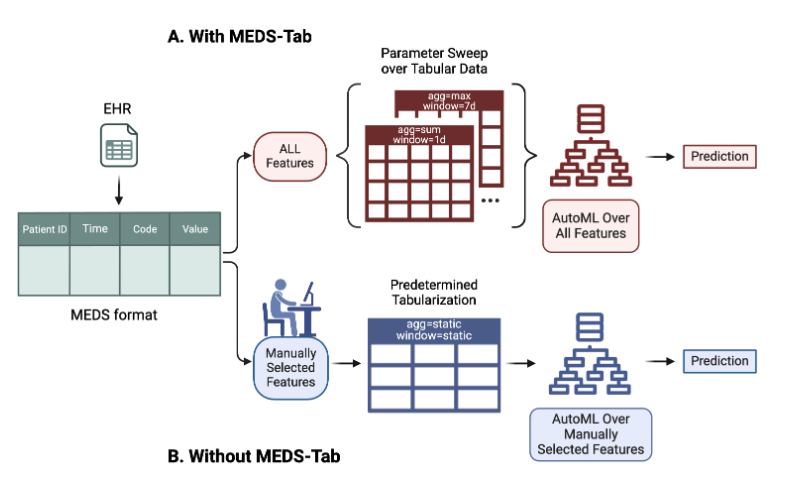

In this case, the whole model-building process could take just a few commands, such as

```bash
meds-tab-tabularize-time-series \
    --multirun \
    worker="range(0,$N_PARALLEL_WORKERS)" \
    hydra/launcher=joblib \
    "input_dir=${MEDS_RESHARD_DIR}/data" \
    "output_dir=$OUTPUT_DIR" \
    tabularization.min_code_inclusion_count=10 \
    tabularization.window_sizes=[1d,30d,365d,full] \
    tabularization.aggs=[static/present,static/first,code/count,value/count,value/sum,value/sum_sqd,value/min,value/max]
```

Feel free to check out the GitHub repository, the [usage guide](https://meds-tab.readthedocs.io/en/latest/usage_guide/) or the [preprint](http://arxiv.org/abs/2411.00200) for more information.